<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Synchronous Gradient Descent CNN Research
In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

The CNN will be trained using the CiFAR dataset which will predict images out of 10 classes and multiple trials of the experiment will be done.

https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

In [0]:
# To run Keras on any GPUs on the computer, this line must be included
# !pip3 install tensorflow-gpu
# !pip3 install scipy
# !pip3 install Pillow

In [0]:
# Obtain the imports for the project
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt


NUM_CLASSES = 10
EPOCHS = 100
BATCH_SIZE = 128


# Preprocessing the dataset
This is the step where visualization and preprocessing is done in the CIFAR10 dataset that Keras gives us.

In [75]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("The shape of the training data is " + str(x_train.shape) + " and the shape of the labels are " + str(y_train.shape))

The shape of the training data is (50000, 32, 32, 3) and the shape of the labels are (50000, 1)


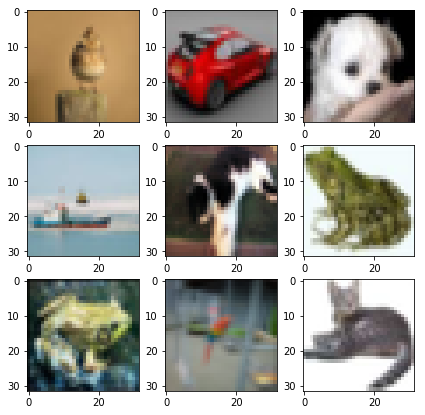

In [76]:
def visualize_cifar(train_data):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(random.choice(train_data))

visualize_cifar(x_train)


In [0]:
def normalize_data(x_train, x_test):
  """ Normalizes the data by dividing by subtracting the mean 
      and dividing by the standard deviation. Akin to scikit-learn's
      StandardScaler."""
  mean_train, mean_test = np.mean(x_train), np.mean(x_test)
  std_train, std_test = np.std(x_train), np.std(x_test)
  return ((x_train - mean_train) / std_train, (x_test - mean_test) / std_test)
  

In [0]:
def smooth_label(labels, epsillion):
  """ Adds a smooth labeling to all the one-hot encoded labels to prevent overfitting
      in the dataset: https://tinyurl.com/kerastricks"""
  if 0 <= epsillion <= 1:
    labels *= (1.0 - epsillion)
    labels += (epsillion / labels.shape[1])
  else:
    raise Exception("Label smoothing factor should be between 0 and 1. Your factor is: " + str(epsillion))
  
  return labels
  

And now, we prepare the data for preprocessing!

In [79]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train, x_test = normalize_data(x_train, x_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

smooth_label(y_train, 0.1)
print(y_train[0])

# Preprocessing the image dataset by artificially increasing the training data size
# via rescaling, shifting, flipping and rotating the dataset.
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    rotation_range=90, 
    width_shift_range=.2, 
    height_shift_range=.2, 
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.0, 1.0),
    rescale=2)

data_gen.fit(x_train)

reg_factor = 0.005 # Regularization factor for L2 Regularization

[0.01       0.01       0.01       0.01       0.01       0.01
 0.90999997 0.01       0.01       0.01      ]


# Building The Model
The models were built by using a combination of methods from the Inceptionv3 model and the VGGNet models that are on Github. The layers used are given in the imports in the first code cell.

In [0]:

def create_conv_net1():
  model = tf.keras.models.Sequential()
  
  # Layer 1
  model.add(tf.keras.layers.Conv2D(32, (3, 1), kernel_initializer="he_normal", input_shape=(32, 32, 3), 
                   padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(32, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))  
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
            
  # Layer 2
  model.add(tf.keras.layers.Conv2D(64, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Dropout(.3))          
            
  # Layer 3
  model.add(tf.keras.layers.Conv2D(128, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(128, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
            
  # Layer 4
  model.add(tf.keras.layers.Conv2D(256, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(256, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
   
 
  # Layer 5
  model.add(tf.keras.layers.Conv2D(512, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(512, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Dropout(.5)) 
  
            
  # Layer 6 
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  # model.add(tf.keras.layers.BatchNormalization())
  
  # Layer 7
  model.add(tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  # model.add(tf.keras.layers.BatchNormalization())
            
  # Layer 8 
  model.add(tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(.5))
            
  # Layer 9
  # model.add(GlobalAveragePooling2D())
  model.add(tf.keras.layers.Dense(NUM_CLASSES))
  model.add(tf.keras.layers.Activation('softmax'))
  
  return model
           

In [0]:
def create_conv_net2():
  model = tf.keras.models.Sequential()
  
  # Layer 1
  model.add(tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer="he_normal", input_shape=(32, 32, 3), 
                   padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Conv2D(128, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))  
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  
  
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
            
  # Layer 2
  model.add(tf.keras.layers.Conv2D(256, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Conv2D(256, 1, padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
            
                       
  model.add(tf.keras.layers.Conv2D(256, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Dropout(.2))          
            
  # Layer 3
  model.add(tf.keras.layers.Conv2D(512, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Conv2D(512, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
            
  # Layer 4
  model.add(tf.keras.layers.Conv2D(1024, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Conv2D(1024, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
   
 
  # Layer 5
  model.add(tf.keras.layers.Conv2D(2056, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(2056, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  
  model.add(tf.keras.layers.MaxPooling2D(1, 1))
  model.add(tf.keras.layers.Dropout(.2)) 
            
#   Layer 6 
#   model.add(tf.keras.layers.Flatten())
#   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
#   model.add(tf.keras.layers.Activation('relu'))
#   # model.add(tf.keras.layers.BatchNormalization())
  
#   # Layer 7
#   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
#   model.add(tf.keras.layers.Activation('relu'))
#   # model.add(tf.keras.layers.BatchNormalization())
            
#   # Layer 8 
#   model.add(tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
#   model.add(tf.keras.layers.Activation('relu'))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.Dropout(.2))
            
 # Layer 9
  model.add(tf.keras.layers.AveragePooling2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(NUM_CLASSES))
  model.add(tf.keras.layers.Activation('softmax'))
  
  return model

In [0]:
def create_conv_net3():
  model = tf.keras.models.Sequential()
  
  # Layer 1
  model.add(tf.keras.layers.Conv2D(128, (3, 1), kernel_initializer="he_normal", input_shape=(32, 32, 3), 
                   padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(128, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))  
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.BatchNormalization())
  
            
  # Layer 2
  model.add(tf.keras.layers.Conv2D(256, (3, 1), strides=(2,2), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Conv2D(256, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
          
            
  # Layer 3
  model.add(tf.keras.layers.Conv2D(512, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Conv2D(512, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  
            
  # Layer 4
  model.add(tf.keras.layers.Conv2D(1024, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Conv2D(1024, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
   
 
  # Layer 5
  model.add(tf.keras.layers.Conv2D(2056, (3, 1), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))

  model.add(tf.keras.layers.Conv2D(2056, (1, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  
  # model.add(tf.keras.layers.Dropout(.2)) 
            
#   Layer 6 
#   model.add(tf.keras.layers.Flatten())
#   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
#   model.add(tf.keras.layers.Activation('relu'))
#   # model.add(tf.keras.layers.BatchNormalization())
  
#   # Layer 7
#   model.add(tf.keras.layers.Dense(2056, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
#   model.add(tf.keras.layers.Activation('relu'))
#   # model.add(tf.keras.layers.BatchNormalization())
            
#   # Layer 8 
#   model.add(tf.keras.layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(reg_factor)))
#   model.add(tf.keras.layers.Activation('relu'))
#   model.add(tf.keras.layers.BatchNormalization())
#   model.add(tf.keras.layers.Dropout(.2))
            
 # Layer 9
  model.add(tf.keras.layers.AveragePooling2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(NUM_CLASSES))
  model.add(tf.keras.layers.Activation('softmax'))
  
  return model

Now, we print the models to see their summary and number of parameters in each.

In [86]:
model1 = create_conv_net1()
model2 = create_conv_net2()
model3 = create_conv_net3()

model1.summary()
print()
model2.summary()
print()
model3.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 32, 32, 128)       1280      
_________________________________________________________________
activation_210 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 32, 32, 128)       49280     
_________________________________________________________________
activation_211 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_190 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 16, 16, 256)     

# Executing the Model
Now, the model built above will be executed with the training set. If there are more than one GPUs on the computer this file is being called in, then it will parallelize the model between the GPUs, else it will execute on the one GPU and CPU. 

In [87]:
# First, check the available amount of parallel GPUs
print(tf.keras.__version__)
# if '2.' in tf.keras.__version__:
#   from keras import backend as K
#   gpus = K.tensorflow_backend._get_available_gpus()
#   print('Available GPUs on this device are: ' + str(gpus))

#   isParallel = len(gpus) > 1
# else:
isParallel = False # toggle for testing purposes

2.2.4-tf


In [88]:
# Now, run the model.
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov = True)
# optimizer = tf.keras.optimizers.Adam(epsilon=1e-8)
history = None

if isParallel:
  print('GPUs parallelized!')
  multi_gpu_model = tf.keras.utils.multi_gpu_model(model2, 1)
  history = multi_gpu_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
  multi_gpu_model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))
else:
  print('CPU Compilation')
  
  history = model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
                metrics=['accuracy'])
  model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))

with open('model1.txt') as file:
  file.write(history)

CPU Compilation
Epoch 1/100
 10/390 [..............................] - ETA: 11:50 - loss: 48.7191 - acc: 0.1187

KeyboardInterrupt: ignored

In [0]:
# Now, run the model.
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov = True)
# optimizer = tf.keras.optimizers.Adam(epsilon=1e-8)
history = None

if isParallel:
  print('GPUs parallelized!')
  multi_gpu_model = tf.keras.utils.multi_gpu_model(model2, 2)
  history = multi_gpu_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
  multi_gpu_model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))
else:
  print('CPU Compilation')
  
  history = model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
                metrics=['accuracy'])
  model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))

with open('model2.txt') as file:
  file.write(history)

In [0]:
# Now, run the model.
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov = True)
# optimizer = tf.keras.optimizers.Adam(epsilon=1e-8)
history = None

if isParallel:
  print('GPUs parallelized!')
  multi_gpu_model = tf.keras.utils.multi_gpu_model(model3, 2)
  history = multi_gpu_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
  multi_gpu_model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))
else:
  print('CPU Compilation')
  
  history = model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
                metrics=['accuracy'])
  model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))

with open('model3.txt') as file:
  file.write(history)